### Project Title:

Comparison of three types of DL models in correctly classifying text inputs to five labels using Glove embedding weights.

### Author: Luca D'Alessandro

### Objective:

This notebook aims to compare the accuracies of three types of DL architectures after Glove embeddings of text inputs. The task is to correctly assign text coming from articles to a political bias ("left", "right", "lean right", "lean left", "center")

DL models are respectively based on:\
1) Conv1D layers;\
2) Multi-head attention layer;\
3) Bidirectional-LSTM layers

### Conclusions:

Bidirectional-LSTM based architecture reaches the best performance in terms of accuracy, altought performance drops when classifying small-size classes.



## Import useful modules

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, TextVectorization, SpatialDropout1D, Dropout, \
                                    Bidirectional, MultiHeadAttention, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

import re
import string
import nltk
nltk.download("stopwords")
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Import data

In [ ]:
data = pd.read_csv("Political_Bias.csv", encoding="utf-8").dropna()

In [ ]:
data.head()

,Title,Link,Text,Source,Bias
0,John Boltonâ€™s Advice for the â€˜Continuing T...,https://thedispatch.com/article/john-boltons-a...,"With just days until his inauguration, it woul...",TheDispatch,lean right
1,Why Shrubland Makes Southern Californiaâ€™s Wi...,https://thedispatch.com/newsletter/techne/why-...,"Welcome back to Techne! In Star Trek, writers ...",TheDispatch,lean right
2,Los Angelesâ€™ Destruction Was Fueled by Bad P...,https://thedispatch.com/newsletter/capitolism/...,"As fire still rages in the Los Angeles area, I...",TheDispatch,lean right
3,Acquiring Greenland Is a Good Idea. Threatenin...,https://thedispatch.com/article/acquiring-gree...,"Whether it was Will Rogers or Tony Soprano, th...",TheDispatch,lean right
4,Assessing Trumpâ€™s Expansionist Designs,https://thedispatch.com/newsletter/morning/ass...,"Happy Friday! If anyone was wondering, Belgium...",TheDispatch,lean right


## Retain only texts no longer than 500 characters (due to computing limitations)

In [ ]:
sentence_len = data.Text.str.split().str.len()
len_threshold = 500
data = data[sentence_len <= len_threshold]

In [ ]:
data.shape

(1928, 5)

## drop duplictaed text

In [ ]:
data = data.drop_duplicates(subset=["Text"])

In [ ]:
data.shape

(1119, 5)

## Visualize class sizes

<BarContainer object of 5 artists>

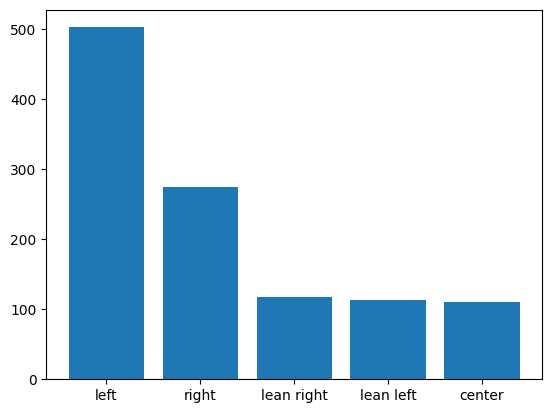

In [ ]:
plt.bar(data["Bias"].value_counts().index, data["Bias"].value_counts().values)

## Text preprocessing

In [ ]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r"\d+", "", text)
  text = re.sub(r"[^\w\s]", "", text)

  tokens = nltk.word_tokenize(text)

  return tokens

In [ ]:
def remove_stopwords(tokens):
  stop_words = set(stopwords.words("english"))
  filtered_tokens = [word for word in tokens if word not in stop_words]
  return filtered_tokens

In [ ]:
def perform_lemmatization(filtered_tokens):
  lemmatizer = nltk.WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
  return lemmatized_tokens

In [ ]:
def clean_text(text):
  tokens = preprocess_text(text)
  filtered_tokens = remove_stopwords(tokens)
  lemmatized_tokens = perform_lemmatization(filtered_tokens)

  return " ".join(lemmatized_tokens)

In [ ]:
data["Cleaned text"] = data["Text"].apply(clean_text)

## Word cloud

In [ ]:
left = data[data["Bias"] == "left"]
right = data[data["Bias"] == "right"]
center = data[data["Bias"] == "center"]

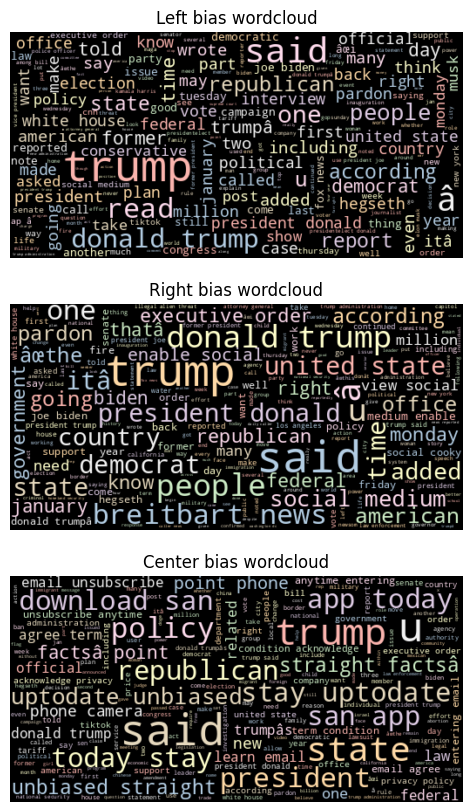

In [ ]:
left_cloud = WordCloud(width =520,
                          height =260,
                          stopwords = STOPWORDS,
                          max_font_size = 50,
                          background_color = "black",
                          colormap = 'Pastel1').generate(left["Cleaned text"].str.cat())
right_cloud = WordCloud(width =520,
                          height =260,
                          stopwords = STOPWORDS,
                          max_font_size = 50,
                          background_color = "black",
                          colormap = 'Pastel1').generate(right["Cleaned text"].str.cat())
center_cloud = WordCloud(width =520,
                          height =260,
                          stopwords = STOPWORDS,
                          max_font_size = 50,
                          background_color = "black",
                          colormap = 'Pastel1').generate(center["Cleaned text"].str.cat())

fig, axes = plt.subplots(3,1,figsize = (10,10))

axes[0].imshow(left_cloud, interpolation = 'bilinear')
axes[0].axis('off') # turn off axis
axes[0].set_title("Left bias wordcloud")

axes[1].imshow(right_cloud, interpolation = 'bilinear')
axes[1].axis('off') # turn off axis
axes[1].set_title("Right bias wordcloud")

axes[2].imshow(center_cloud, interpolation = 'bilinear')
axes[2].axis('off') # turn off axis
axes[2].set_title("Center bias wordcloud")
plt.show()

## split data

In [ ]:
X = data["Cleaned text"]
y = data["Bias"]

y = pd.factorize(y)[0]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## Text vetorization and indexing

In [ ]:
number_of_words = len(np.unique(np.array(data.Text.str.cat().split(" "))))
number_of_words

41960

In [ ]:
max_length = int(data.Text.str.split().str.len().max())
max_length

500

In [ ]:
vectorizer = TextVectorization(max_tokens=number_of_words, output_sequence_length=max_length)
vectorizer.adapt(data.Text.values)

In [ ]:
len(vectorizer.get_vocabulary())

25024

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
len(word_index)

25024

## Load Glove embedding weights (200d version)

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-03-20 20:09:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2025-03-20 20:12:07 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
with open("glove.6B.200d.txt", "r") as f:
    lines = f.readlines()

## Create weigths matrix (dimension: number of words x embedding dimension)

In [ ]:
embeddings_index = {}
for line in lines:
  word, coefs = line.split(maxsplit=1)
  coefs = np.fromstring(coefs, "f", sep=" ")
  embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

embedding_matrix = np.zeros((len(voc), embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

## Create Embedding layer using Glove weights matrix

In [ ]:
num_tokens = len(voc)

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

## Model 1: Conv1D

In [ ]:
sequence_input = Input(shape=(1,), dtype="string")
vectorized_sequence = vectorizer(sequence_input)
embedded_sequence = embedding_layer(vectorized_sequence)
x = SpatialDropout1D(0.2)(embedded_sequence)
x = Conv1D(128, 5, activation="relu")(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation="relu")(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
preds = Dense(5, activation="softmax")(x)

model1 = Model(sequence_input, preds)
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 500, 200)            │       5,004,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 500, 200)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 496, 128)            │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 99, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 95, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 15, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,314,181 (20.27 MB)

 Trainable params: 309,381 (1.18 MB)

 Non-trainable params: 5,004,800 (19.09 MB)

In [ ]:
model1.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
r1 = model1.fit(X_train.values, y_train, batch_size=64, epochs=20, validation_data=(X_test.values, y_test))

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - acc: 0.3720 - loss: 1.5345 - val_acc: 0.5089 - val_loss: 1.3465
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - acc: 0.4526 - loss: 1.3786 - val_acc: 0.5223 - val_loss: 1.3822
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.4707 - loss: 1.3721 - val_acc: 0.6027 - val_loss: 1.2651
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - acc: 0.5591 - loss: 1.2200 - val_acc: 0.5982 - val_loss: 1.1421
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.6127 - loss: 1.0934 - val_acc: 0.6473 - val_loss: 1.0895
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.6855 - loss: 0.9281 - val_acc: 0.6741 - val_loss: 0.9652
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.7492 - loss: 0.7084 - val_acc: 0.6875 - val_loss: 0.9170
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.7513 - loss: 0.6662 - val_acc: 0.6875 - val_loss: 0.9490
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.785

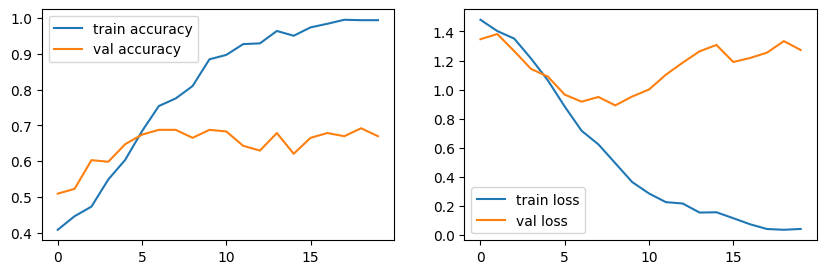

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(r1.history["acc"], label = "train accuracy")
plt.plot(r1.history["val_acc"], label = "val accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(r1.history["loss"], label = "train loss")
plt.plot(r1.history["val_loss"], label = "val loss")
plt.legend()

plt.show()

## Model 2: Multi-head Attention

In [ ]:
sequence_input = Input(shape=(1,), dtype="string")
vectorized_sequence = vectorizer(sequence_input)
embedded_sequences = embedding_layer(vectorized_sequence)
x = SpatialDropout1D(0.2)(embedded_sequences)

# Multi-Head Self-Attention
attention = MultiHeadAttention(num_heads=4, key_dim=50)(x,x)

x = GlobalMaxPooling1D()(attention)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
preds = Dense(5, activation="softmax")(x)

model2 = Model(sequence_input, preds)
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 500)            │              0 │ input_layer_2[0][0]    │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 200)       │      5,004,800 │ text_vectorization[2]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_2       │ (None, 500, 200)       │              0 │ embedding[2][0]        │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 500, 200)       │        160,800 │ spatial_dropout1d_2[0… │
│ (MultiHeadAttention)      │                        │                │ spatial_dropout1d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 200)            │              0 │ multi_head_attention_… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │         12,864 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          4,160 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 5)              │            325 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,182,949 (19.77 MB)

 Trainable params: 178,149 (695.89 KB)

 Non-trainable params: 5,004,800 (19.09 MB)

In [ ]:
model2.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
r2 = model2.fit(X_train.values,y_train, batch_size=32, epochs=20, validation_data=(X_test.values,y_test))

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - acc: 0.3883 - loss: 1.5403 - val_acc: 0.5089 - val_loss: 1.3514
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.4159 - loss: 1.3932 - val_acc: 0.5134 - val_loss: 1.2779
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - acc: 0.4467 - loss: 1.3389 - val_acc: 0.5223 - val_loss: 1.1811
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.4808 - loss: 1.2164 - val_acc: 0.5223 - val_loss: 1.1460
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.5393 - loss: 1.1264 - val_acc: 0.5848 - val_loss: 1.0712
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.6341 - loss: 0.9999 - val_acc: 0.6205 - val_loss: 0.9776
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 0.6866 - loss: 0.8163 - val_acc: 0.6518 - val_loss: 0.9321
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.6876 - loss: 0.8270 - val_acc: 0.6384 - val_loss: 0.9856
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.6791

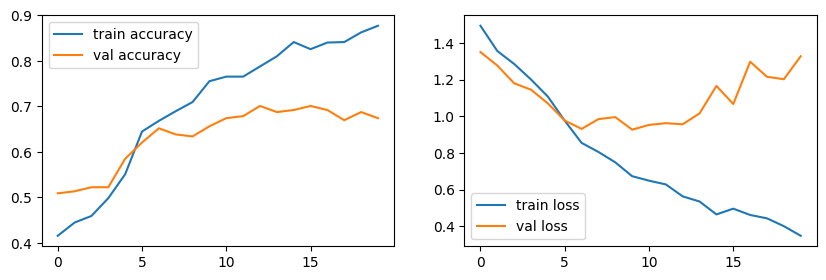

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(r2.history["acc"], label = "train accuracy")
plt.plot(r2.history["val_acc"], label = "val accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(r2.history["loss"], label = "train loss")
plt.plot(r2.history["val_loss"], label = "val loss")
plt.legend()

plt.show()

## Model 3: Bidirectional LSTM

In [ ]:
sequence_input = Input(shape=(1,), dtype="string")
vectorized_sequence = vectorizer(sequence_input)
embedded_sequences = embedding_layer(vectorized_sequence)

x = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
preds = Dense(5, activation="softmax")(x)

model3 = Model(sequence_input, preds)
model3.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 500, 200)            │       5,004,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_3                  │ (None, 500, 200)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 500, 256)            │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,362,629 (20.46 MB)

 Trainable params: 357,829 (1.37 MB)

 Non-trainable params: 5,004,800 (19.09 MB)

In [ ]:
model3.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)

r3 = model3.fit(X_train.values,y_train, batch_size=32, epochs=20, validation_data=(X_test.values,y_test))

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - acc: 0.4442 - loss: 1.4901 - val_acc: 0.5089 - val_loss: 1.3339
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - acc: 0.4010 - loss: 1.4190 - val_acc: 0.5089 - val_loss: 1.2673
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - acc: 0.4673 - loss: 1.3114 - val_acc: 0.5536 - val_loss: 1.1630
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.5351 - loss: 1.2271 - val_acc: 0.6161 - val_loss: 1.0631
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.6465 - loss: 0.9858 - val_acc: 0.6473 - val_loss: 0.9519
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - acc: 0.7218 - loss: 0.8123 - val_acc: 0.7054 - val_loss: 0.8402
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.7632 - loss: 0.6944 - val_acc: 0.6964 - val_loss: 0.8278
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - acc: 0.7971 - loss: 0.6093 - val_acc: 0.7321 - val_loss: 0.7886
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - acc: 0.8163

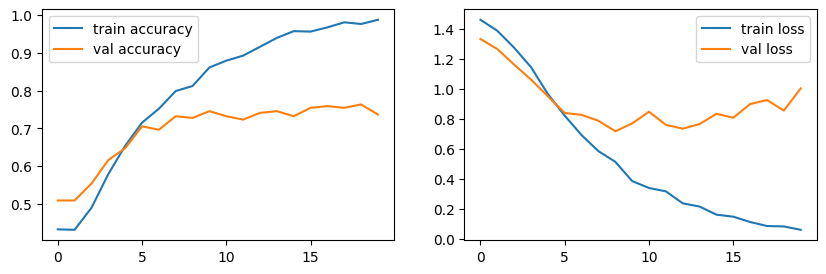

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(r3.history["acc"], label = "train accuracy")
plt.plot(r3.history["val_acc"], label = "val accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(r3.history["loss"], label = "train loss")
plt.plot(r3.history["val_loss"], label = "val loss")
plt.legend()

plt.show()

All the three models seem to overfit. However, let's use the third model (which seems to perform best), on test data

## Performance of test set (model 3)

In [ ]:
y_pred = np.argmax(model3.predict(X_test.values), axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [ ]:
len(y_pred), len(y_test)

(224, 224)

In [ ]:
from sklearn.metrics import confusion_matrix as cm, accuracy_score
conf_mat = cm(y_test, y_pred)
print(f"Confusion matrix:\n{conf_mat}")
print("\n")
print(f"Accuracy score: {np.round(accuracy_score(y_test, y_pred),2)}")

Confusion matrix:
[[ 10   2   0   5   9]
 [  5  30   1   3   6]
 [  3   2  10   3   2]
 [  2   2   0   8   7]
 [  4   0   2   1 107]]


Accuracy score: 0.74


In [ ]:
factor_to_label = dict(zip(range(5), ["lean rigth", "right", "center", "lean left", "left"]))

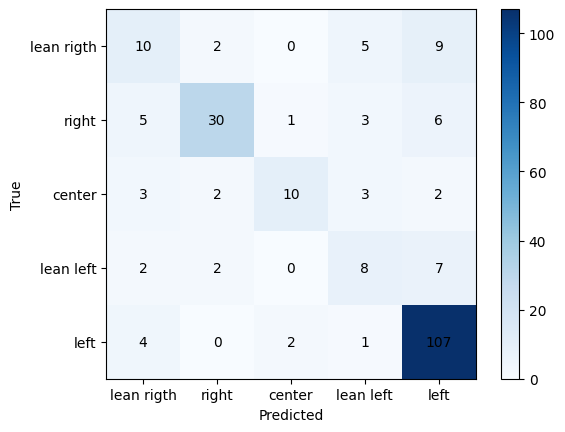

In [ ]:
plt.imshow(cm(y_test, y_pred), cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(5), list(factor_to_label.values()))
plt.yticks(np.arange(5), list(factor_to_label.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(5):
  for j in range(5):
    plt.text(j,i, conf_mat[i,j], ha = "center", va = "center")
plt.show()

The model does a good job when classifying the higher-size class ("left"), whilst its performance drop for the other classes